In [49]:
rm(list=ls())
load("Grantham_dist/age_gap_restrict_with_divergence_data.RData")

library(lme4)
library(lmerTest)
library(ggplot2)
library(dplyr)
library(cowplot)
library(stevemisc)

###change categoreis to be either chosen or arranged

age_gap_restrict$informal_relationship <- age_gap_restrict$inf_ped
age_gap_restrict$inf_ped <- 0
age_gap_restrict[age_gap_restrict$informal == 1 | age_gap_restrict$pedigree == 1, "inf_ped"] <- 1
age_gap_restrict$chosen <- 0
age_gap_restrict[age_gap_restrict$inf_ped == 1 | age_gap_restrict$love_marriage == 1 , "chosen" ] <- 1

no_relatives <- age_gap_restrict[age_gap_restrict$close_relative == 0, ]

table(age_gap_restrict$close_relative)
table(age_gap_restrict$chosen)
table(age_gap_restrict$arranged)
#no close relative background pairs (2nd degree or closer)
age_gap_restrict <- age_gap_restrict[age_gap_restrict$close_relative == 0,]



    0     1 
18736   250 


    0     1 
18784   202 


    0     1 
18939    47 

In [50]:
###functions
generate_contrasts <- function(model, num_fixed_effects) {
  # Extract variable names (assuming the first variable is the Intercept)
  var_names <- names(fixef(model))
  contrast_list <- list()
  
  # Debugging: Print the variable names and num_fixed_effects
  print("Variable names in the model:")
  print(var_names)
  print(paste("Number of fixed effects:", num_fixed_effects))
  
  # Determine starting index based on presence of "IBD"
  if ("IBD" %in% var_names) {
    i <- 3
  } else {
    i <- 2
  }
  
  print(paste("Starting index i:", i))
  
  # Loop through pairwise combinations
  while (i <= num_fixed_effects) {
    j <- i + 1
    while (j <= num_fixed_effects) {
      # Create a contrast vector
      contrast_vector <- rep(0, num_fixed_effects)
      contrast_vector[i] <- 1
      contrast_vector[j] <- -1
      
      # Store the contrast vector with a descriptive name
      contrast_name <- paste(var_names[i], "vs", var_names[j])
      contrast_list[[contrast_name]] <- contrast_vector
      j <- j + 1
    }
    i <- i + 1
  }
  
  # Debugging: Check final contrast list
 # print("Generated contrast list:")
  #print(contrast_list)
  
  # Return the list of contrast vectors
  return(contrast_list)
}

plot_contrast <- function(contrast_vector, model, contrast_name) {
  fixef_model <- fixef(model)
  vcov_model <- vcov(model)
  
  # Check contrast vector length
  if (length(contrast_vector) != length(fixef_model)) {
    stop("Length of contrast vector does not match the number of fixed effects.")
  }
  
  # Calculate contrast estimate and standard error
  contrast_estimate <- as.numeric(t(contrast_vector) %*% fixef_model)
  contrast_SE <- as.numeric(sqrt(t(contrast_vector) %*% vcov_model %*% contrast_vector))
  
  # Calculate 95% confidence intervals
  lower_CI <- contrast_estimate - 1.96 * contrast_SE
  upper_CI <- contrast_estimate + 1.96 * contrast_SE
  
  # Calculate z-value and p-value
  z_value <- as.numeric(contrast_estimate / contrast_SE)  # Ensure z_value is numeric
  p_value <- 2 * (1 - pnorm(abs(z_value)))  # Two-tailed p-value
  
  # Return data frame for plotting
  return(data.frame(
    contrast = contrast_name,
    estimate = contrast_estimate,
    lower_CI = lower_CI,
    upper_CI = upper_CI,
    z_value = z_value,
    p_value = p_value
  ))
}


# Function to plot all contrasts with custom title
plot_all_contrasts <- function(model, num_fixed_effects, y_var) {
  # Generate all contrasts
  contrast_vectors <- generate_contrasts(model, num_fixed_effects)
  
  # Create a combined data frame with all contrasts
  contrast_results <- do.call(rbind, lapply(names(contrast_vectors), function(contrast_name) {
    contrast_vector <- contrast_vectors[[contrast_name]]
    plot_contrast(contrast_vector, model, contrast_name)
  }))
  print(contrast_results)
  # Convert the contrast column to a factor to retain the order in the plot
  contrast_results$contrast <- factor(contrast_results$contrast, levels = contrast_results$contrast)
  print(contrast_results)
  # Plot using ggplot2
  ggplot(contrast_results, aes(x = contrast, y = estimate)) +
    geom_point(size = 4, color = "blue") +  # Point estimate
    geom_errorbar(aes(ymin = lower_CI, ymax = upper_CI), width = 0.2, color = "blue") +  # 95% CI
    theme_minimal() +  # Clean theme
    labs(
      title = "Pairwise Contrasts",
      y = paste0("Difference between pair types in their effect on ", y_var),
      x = ""
    ) +
      theme(
      text = element_text(size = 18),
      axis.text = element_text(size = 18),  # Increase font size for axis ticks
      axis.title = element_text(size = 18),  # Increase font size for axis labels
      plot.title = element_text(hjust = 0.5, size = 18)  # Increase title font size
    )  +
    
    scale_x_discrete(
      labels = c(
        "love_marriage vs informal_relationship" = "Love Marriage vs Informal",
        "arranged vs informal_relationship" = "Arranged Marriage vs Informal",
        "arranged vs love_marriage" = "Arranged Marriage vs Love Marriage"
      )
    ) +
    coord_flip()  # Flip coordinates for better readability
}
get_effects <- function(model) {
  # Extract fixed effects and variance-covariance matrix
  fixef_model <- fixef(model)
  vcov_model <- vcov(model)
  
  # Debug: Print the names of the coefficients to check for issues
  print("Fixed Effects Coefficients:")
  print(names(fixef_model))

  # Define variable names (excluding intercept)
  variables <- names(fixef_model)
  
  # Filter variables to ensure they exist in the model
  variables <- variables[variables %in% names(fixef_model)]
  #print(variables)
  variables <- variables[!variables %in% c("(Intercept)", "IBD")]
  # Create a data frame to store estimates and confidence intervals
  effects_df <- data.frame(
    variable = variables,
    estimate = fixef_model[variables],
    stringsAsFactors = FALSE
  )
  
  # Ensure the variance-covariance matrix is correctly indexed
  if (length(variables) > 0) {
    # Calculate standard errors and 95% confidence intervals
    effects_df$se <- sqrt(diag(vcov_model[variables, variables, drop = FALSE]))
    effects_df$lower_CI <- effects_df$estimate - 1.96 * effects_df$se
    effects_df$upper_CI <- effects_df$estimate + 1.96 * effects_df$se
  } else {
    stop("No valid variables found in the model.")
  }
  
  #print(effects_df)
  return(effects_df)
}

plot_all_effects <- function(model, plot_title, y_) {
  # Get effects data
  effect_results <- get_effects(model)
  
  # Define custom colors for specific variables
  effect_colors <- c("arranged" = "Dark Orange", "chosen" = "Dodger Blue", "love_marriage" = "black", "informal_relationship" = "black")

  # Ensure 'variable' is a factor with defined levels
  effect_results$variable <- factor(effect_results$variable, levels = names(effect_colors))

  # Plot using ggplot2
  ggplot(effect_results, aes(x = variable, y = estimate, color = variable)) +
    geom_point(size = 4) +  # Point estimate
    geom_errorbar(aes(ymin = lower_CI, ymax = upper_CI), width = 0.2, size = 1.5) +  # 95% CI
    scale_color_manual(values = effect_colors) +  # Apply custom colors
    theme_minimal() +  # Clean theme
    labs(
      title = plot_title,
      y = y_,
      x = "",
      color = "Effect Type"
    ) +
    scale_x_discrete(
      labels = c(
        "love_marriage" = "Love Marriage",
        "informal_relationship" = "Informal",
        "arranged" = "Arranged Partnership",
        "chosen" = "Chosen Partnership"
      )
    ) +
    theme(
      text = element_text(size = 18),
      axis.text = element_text(size = 18),  # Increase font size for axis ticks
      axis.title = element_text(size = 18),  # Increase font size for axis labels
      plot.title = element_text(hjust = 0.5, size = 18)  # Increase title font size
    ) +
    guides(color = "none")  # Remove legend
}
plot_distributions <- function(data, outcome_var, filters, string) {
  # Ensure the filter columns exist in the data
  filtered_data <- data[, colnames(data) %in% filters]
  
  # Add outcome variable to the filtered dataset
  filtered_data[[outcome_var]] <- data[[outcome_var]]
  
  # Create a new column for Effect based on filter values
  filtered_data$Effect <- NA
  if ("arranged" %in% filters) {
    filtered_data$Effect[filtered_data$arranged == 1] <- "Arranged"
  }
  if ("chosen" %in% filters) {
    filtered_data$Effect[filtered_data$chosen == 1] <- "Chosen"
  }
  
  # Remove rows where Effect is still NA (i.e., neither condition met)
  filtered_data <- filtered_data[!is.na(filtered_data$Effect), ]
  
  # Ensure that there are data points for both Effect levels
  if (nrow(filtered_data) == 0) {
    stop("No data available for the specified filters.")
  }

  means <- filtered_data %>%
    group_by(Effect) %>%
    summarise(mean = mean(.data[[outcome_var]], na.rm = TRUE))

  # Create density plot with vertical lines at the median
  plot <- ggplot(filtered_data, aes(x = .data[[outcome_var]], fill = Effect)) +
    geom_density(alpha = 0.5) +  # Overlapping densities
    geom_vline(data = means, aes(xintercept = mean, color = Effect), linetype = "dashed", size = 1.5, show.legend = FALSE) +  # Add dashed vertical lines at the median
    theme_minimal() +
    labs(
      title = NULL,
      x = string,
      y = "Density",
      fill = "Pair Type"
    ) +
    theme(
      text = element_text(size = 18),
      axis.text = element_text(size = 16),
      axis.title = element_text(size = 18),
      plot.title = element_text(hjust = 0.5, size = 20),
    ) +
    scale_fill_manual(values = c("Arranged" = "Dark Orange", "Chosen" = "Dodger Blue")) +  # Custom colors
    scale_color_manual(values = c("Arranged" = "Dark Orange", "Chosen" = "Dodger Blue"))  # Custom colors for the lines

  return(plot)
}

# Function to calculate variance explained by random effects
calculate_random_effect_variance <- function(model) {
  # Extract variance components (standard deviations)
  var_components <- as.data.frame(VarCorr(model))
  print(var_components)
  # Convert standard deviations to variances (by squaring them)
  random_var_actor <- var_components$vcov[1]  # Variance for actorID
  random_var_partner <- var_components$vcov[2]  # Variance for partnerID
  # Residual variance (the "sc" attribute in lmer models gives the residual SD)
  residual_var <- var_components$vcov[3]   # Residual variance
   
  # Calculate total variance
  total_variance <- random_var_actor + random_var_partner + residual_var
  # Calculate variance explained by random effects
  random_effect_variance <- random_var_actor + random_var_partner
  variance_explained_by_random_effects <- random_effect_variance / total_variance
  # Return the result
  return(variance_explained_by_random_effects)
}

[1] "Fixed Effects Coefficients:"
[1] "(Intercept)" "arranged"    "chosen"     
        grp        var1 var2       vcov     sdcor
1   actorID (Intercept) <NA>   635.6121  25.21135
2 partnerID (Intercept) <NA>   992.2620  31.50019
3  Residual        <NA> <NA> 11229.2870 105.96833


[1] 0.1266122

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: IBD ~ 1 + arranged + chosen + (1 | actorID) + (1 | partnerID)
   Data: age_gap_restrict

REML criterion at convergence: 228604.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9483 -0.5260 -0.2159  0.2150  9.4847 

Random effects:
 Groups    Name        Variance Std.Dev.
 actorID   (Intercept)   635.6   25.21  
 partnerID (Intercept)   992.3   31.50  
 Residual              11229.3  105.97  
Number of obs: 18736, groups:  actorID, 215; partnerID, 144

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   165.461      3.301   238.760  50.120   <2e-16 ***
arranged        3.230     15.655 18638.965   0.206    0.837    
chosen          1.761      7.633 18662.445   0.231    0.818    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr) arrngd
arranged -0.019       
chosen   -0.037  

        grp        var1 var2       vcov     sdcor
1   actorID (Intercept) <NA>   635.6121  25.21135
2 partnerID (Intercept) <NA>   992.2620  31.50019
3  Residual        <NA> <NA> 11229.2870 105.96833


[1] 0.1266122

[1] "Variable names in the model:"
[1] "(Intercept)" "arranged"    "chosen"     
[1] "Number of fixed effects: 3"
[1] "Starting index i: 2"


contrast,estimate,lower_CI,upper_CI,z_value,p_value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
arranged vs chosen,1.469125,-32.56957,35.50782,0.08459447,0.9325838


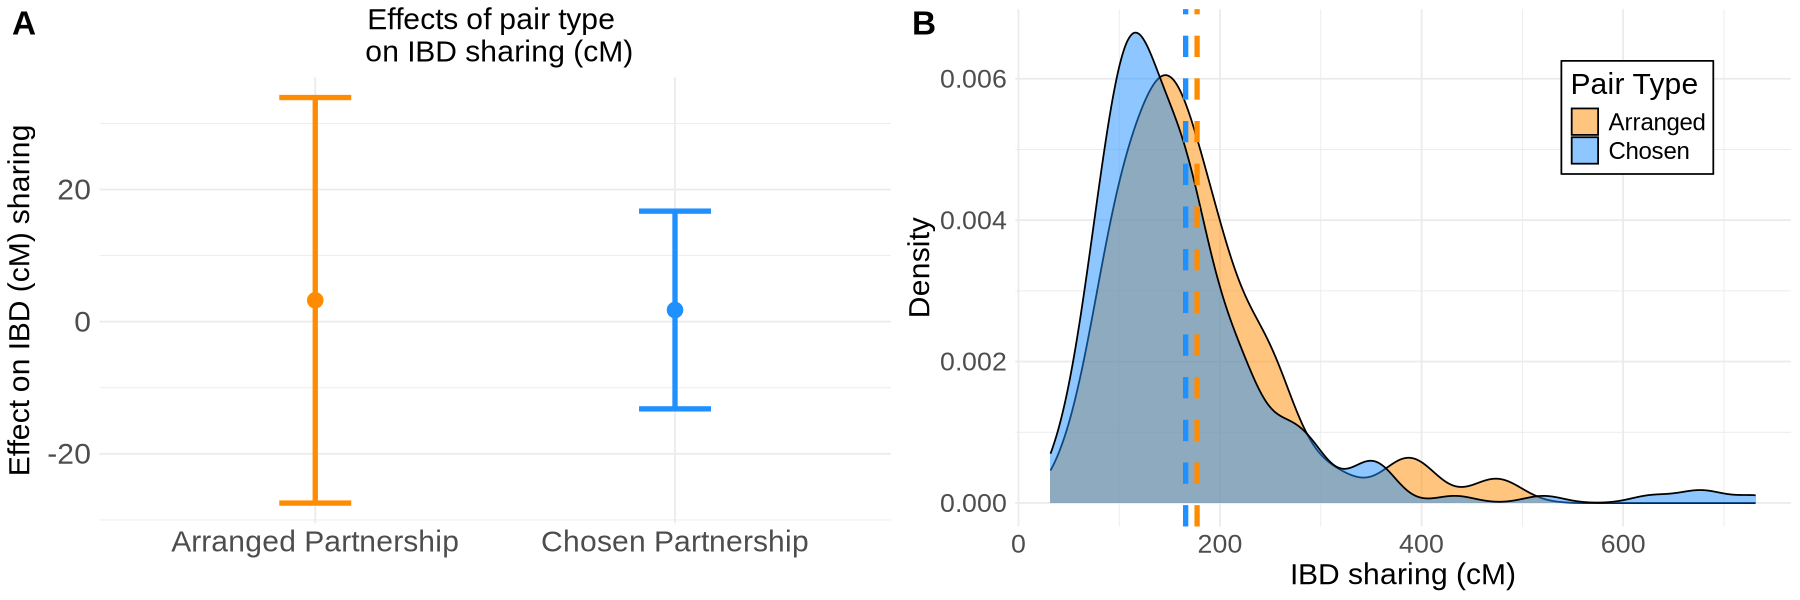

In [51]:
##IBD model figure 1
full_model_IBD <- lmerTest::lmer(IBD ~ 1 + arranged + chosen + (1|actorID) + (1|partnerID), data=age_gap_restrict)
options(repr.plot.width = 15, repr.plot.height = 5)

plot1 <- plot_all_effects(full_model_IBD, plot_title = "Effects of pair type \n on IBD sharing (cM)", y_= "Effect on IBD (cM) sharing")
plot3<- plot_distributions(age_gap_restrict, "IBD", c("arranged", "chosen"), "IBD sharing (cM)")
plot3 <- plot3 + theme(
  legend.position = c(0.9, 0.9),  # Adjust the position as needed (0.9 is near the top-right corner)
  legend.justification = c(1, 1),  # Ensures the legend is aligned to the top-right
  legend.background = element_rect(fill = "white", color = "black")  # Optional: background for the legend
)
plot_grid(plot1, plot3,  ncol = 2, labels = c("A", "B"), label_size = 20, rel_widths = c(1, 1))
calculate_random_effect_variance(full_model_IBD)
cate <- show_ranef(full_model_IBD, "actorID", reorder=FALSE)
catf <- show_ranef(full_model_IBD, "partnerID", reorder=FALSE)
summary(full_model_IBD)
calculate_random_effect_variance(full_model_IBD)

IBD_con <- generate_contrasts(full_model_IBD, 3)


IBD_contrast_results <- do.call(rbind, lapply(names(IBD_con), function(contrast_name) {
    contrast_vector <- IBD_con[[contrast_name]]
    plot_contrast(contrast_vector, full_model_IBD, contrast_name)
  }))

IBD_contrast_results 


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: HLA_sim ~ 1 + IBD + arranged + chosen + (1 | actorID) + (1 |  
    partnerID)
   Data: age_gap_restrict

REML criterion at convergence: 85253.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5820 -0.7135 -0.1695  0.5411  5.9049 

Random effects:
 Groups    Name        Variance Std.Dev.
 actorID   (Intercept) 0.5220   0.7225  
 partnerID (Intercept) 0.5942   0.7708  
 Residual              5.2924   2.3005  
Number of obs: 18736, groups:  actorID, 215; partnerID, 144

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  3.918e+00  8.823e-02  3.283e+02  44.402   <2e-16 ***
IBD          1.924e-03  1.591e-04  1.870e+04  12.097   <2e-16 ***
arranged    -1.332e-01  3.405e-01  1.865e+04  -0.391    0.696    
chosen       8.592e-02  1.660e-01  1.865e+04   0.518    0.605    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Corr

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: HLA_prob ~ 1 + IBD + arranged + chosen + (1 | actorID) + (1 |  
    partnerID)
   Data: age_gap_restrict

REML criterion at convergence: 45876.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5094 -0.7104 -0.1520  0.5452  5.4326 

Random effects:
 Groups    Name        Variance Std.Dev.
 actorID   (Intercept) 0.04838  0.2200  
 partnerID (Intercept) 0.05698  0.2387  
 Residual              0.64957  0.8060  
Number of obs: 18736, groups:  actorID, 215; partnerID, 144

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept) -2.346e+00  2.771e-02  3.339e+02 -84.649   <2e-16 ***
IBD          6.375e-04  5.563e-05  1.872e+04  11.459   <2e-16 ***
arranged    -3.196e-02  1.192e-01  1.864e+04  -0.268    0.789    
chosen       1.489e-02  5.810e-02  1.865e+04   0.256    0.798    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Cor

[1] "Fixed Effects Coefficients:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Fixed Effects Coefficients:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
        grp        var1 var2      vcov     sdcor
1   actorID (Intercept) <NA> 0.5219573 0.7224662
2 partnerID (Intercept) <NA> 0.5941646 0.7708208
3  Residual        <NA> <NA> 5.2923788 2.3005171


[1] 0.1741627

        grp        var1 var2       vcov     sdcor
1   actorID (Intercept) <NA> 0.04838294 0.2199612
2 partnerID (Intercept) <NA> 0.05697697 0.2386985
3  Residual        <NA> <NA> 0.64956523 0.8059561


[1] 0.1395634

[1] "Variable names in the model:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Number of fixed effects: 4"
[1] "Starting index i: 3"
[1] "Variable names in the model:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Number of fixed effects: 4"
[1] "Starting index i: 3"


contrast,estimate,lower_CI,upper_CI,z_value,p_value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
arranged vs chosen,-0.2190681,-0.9592677,0.5211316,-0.5800778,0.5618621


contrast,estimate,lower_CI,upper_CI,z_value,p_value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
arranged vs chosen,-0.04684297,-0.3058985,0.2122126,-0.3544113,0.7230306


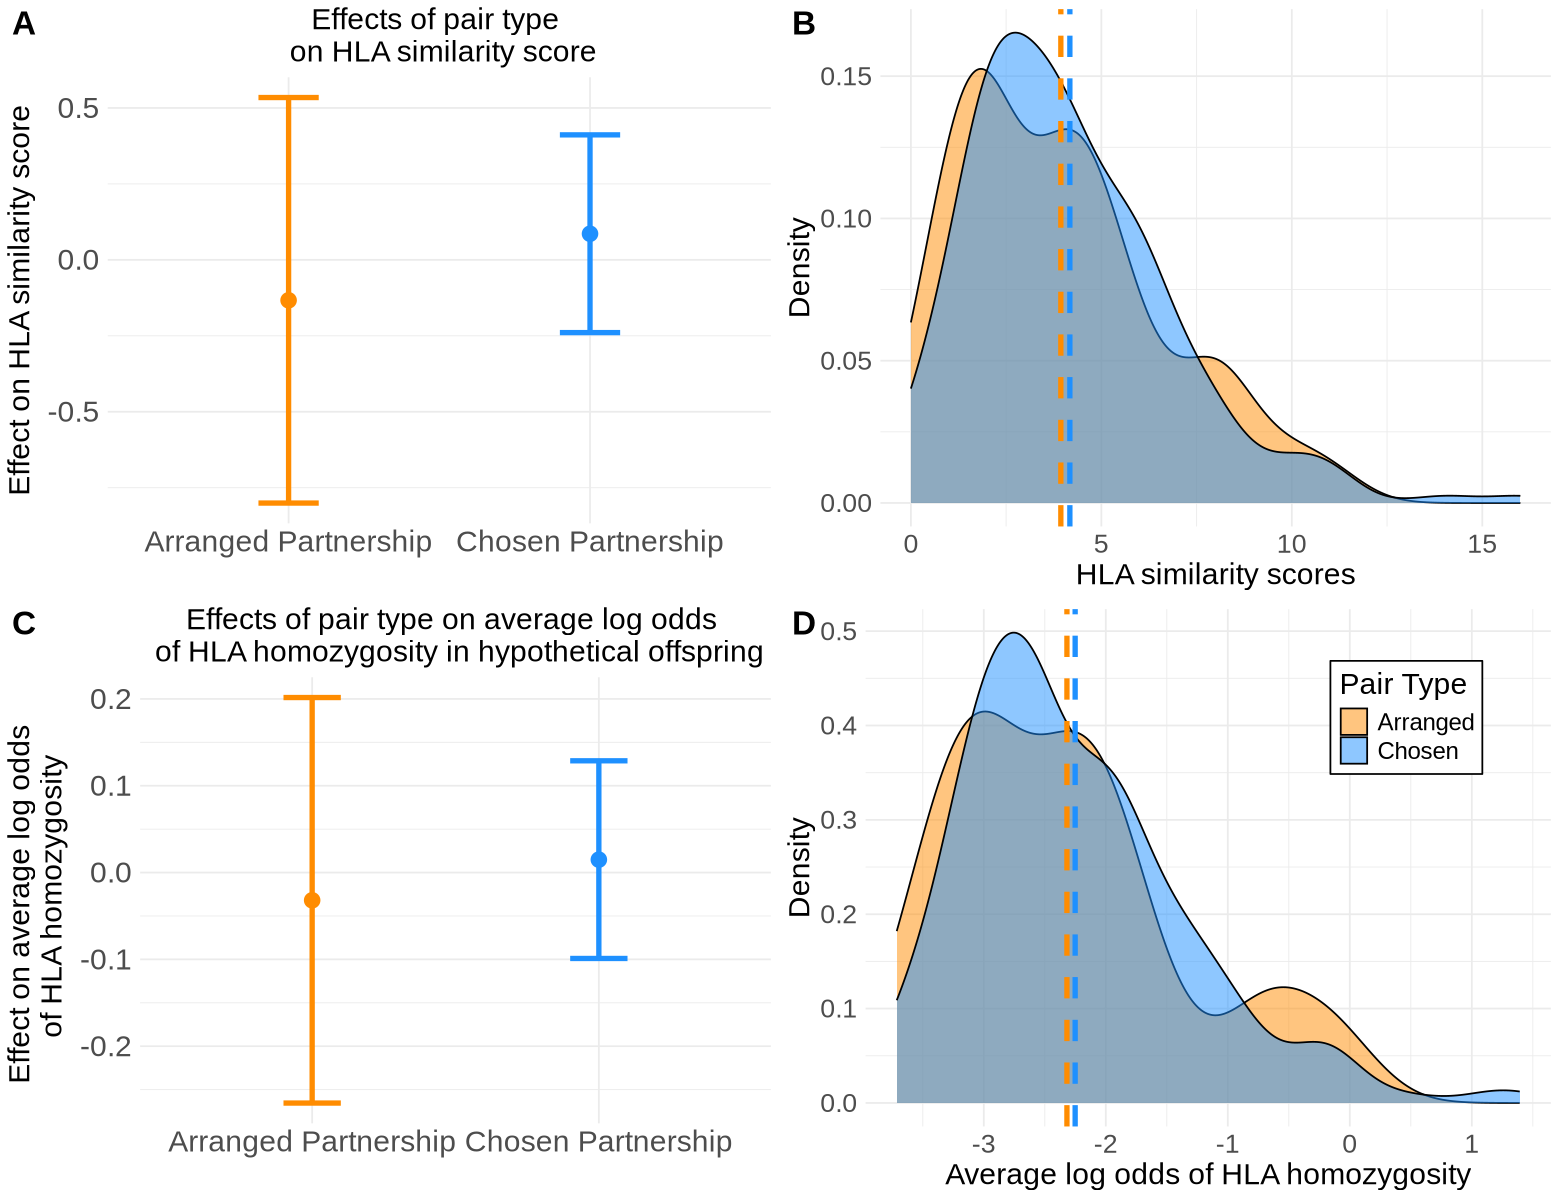

In [56]:
#Similarity and log odds models figure 2
options(repr.plot.width = 10, repr.plot.height = 8)

full_model_sim <- lmerTest::lmer(HLA_sim ~ 1 + IBD + arranged + chosen + (1|actorID) + (1|partnerID), data=age_gap_restrict)
full_model_prob <- lmerTest::lmer(HLA_prob ~ 1 + IBD + arranged + chosen + (1|actorID) + (1|partnerID), data=age_gap_restrict)
summary(full_model_sim)
summary(full_model_prob)
plot1 <- plot_all_effects(full_model_sim, plot_title = "Effects of pair type \n on HLA similarity score", y_= "Effect on HLA similarity score")
plot2 <- plot_all_effects(full_model_prob, plot_title = "Effects of pair type on average log odds \n of HLA homozygosity in hypothetical offspring", y_= "Effect on average log odds \n of HLA homozygosity")

# Example usage:
plot3<- plot_distributions(age_gap_restrict, "HLA_sim", c("arranged", "chosen"), "HLA similarity scores")

plot4<- plot_distributions(age_gap_restrict, "HLA_prob", c("arranged", "chosen"), "Average log odds of HLA homozygosity")
#legend <- get_legend(plot3)
plot3 <- plot3 + theme(legend.position = "none")
plot4 <- plot4 + theme(
  legend.position = c(0.9, 0.9),  # Adjust the position as needed (0.9 is near the top-right corner)
  legend.justification = c(1, 1),  # Ensures the legend is aligned to the top-right
  legend.background = element_rect(fill = "white", color = "black")  # Optional: background for the legend
)

#plot3 <- plot_all_contrasts(full_model_sim, 4, "\n HLA similarity score")
#plot4 <- plot_all_contrasts(full_model_prob, 4, "\n average log odds of HLA homozyosity in offspring")
options(repr.plot.width = 13, repr.plot.height = 10)
library(cowplot)
top <- plot_grid(plot1, plot3, ncol = 2, nrow = 1, labels = c("A", "B"), label_size = 20, rel_widths = c(1, 1))
bottom <- plot_grid(plot2, plot4, ncol=2, nrow=1, labels=c("C", "D"), label_size = 20, rel_widths = c(1, 1))
plot_grid(top, bottom, nrow=2)

calculate_random_effect_variance(full_model_sim)

calculate_random_effect_variance(full_model_prob)

re_actor <- ranef(full_model_sim, condVar = TRUE)$actorID
re_partner <- ranef(full_model_sim, condVar = TRUE)$partnerID


catA <- show_ranef(full_model_sim, "actorID", reorder=FALSE)
catB <- show_ranef(full_model_sim, "partnerID", reorder=FALSE)
catC <-show_ranef(full_model_prob, "actorID",reorder=FALSE)
catD <-show_ranef(full_model_prob, "partnerID", reorder=FALSE)

sim_con <- generate_contrasts(full_model_sim, 4)
prob_con <- generate_contrasts(full_model_prob, 4)


sim_contrast_results <- do.call(rbind, lapply(names(sim_con), function(contrast_name) {
    contrast_vector <- sim_con[[contrast_name]]
    plot_contrast(contrast_vector, full_model_sim, contrast_name)
  }))

sim_contrast_results 

prob_contrast_results <- do.call(rbind, lapply(names(prob_con), function(contrast_name) {
    contrast_vector <- prob_con[[contrast_name]]
    plot_contrast(contrast_vector, full_model_prob, contrast_name)
  }))

prob_contrast_results 


In [57]:
###Pathogen binding analyses Figure S5
A_all <- lmerTest::lmer(mean_SB_all_A ~ 1 + IBD + arranged + chosen + (1|actorID) + (1|partnerID), data=age_gap_restrict)
B_all <- lmerTest::lmer(mean_SB_all_B ~ 1 + IBD + arranged + chosen + (1|actorID) + (1|partnerID), data=age_gap_restrict)
C_all <- lmerTest::lmer(mean_SB_all_C ~ 1 + IBD + arranged + chosen + (1|actorID) + (1|partnerID), data=age_gap_restrict)
DP_all <- lmerTest::lmer(mean_SB_all_DP ~ 1 + IBD + arranged + chosen + (1|actorID) + (1|partnerID), data=age_gap_restrict)
DQ_all <- lmerTest::lmer(mean_SB_all_DQ ~ 1 + IBD + arranged + chosen + (1|actorID) + (1|partnerID), data=age_gap_restrict)
DRB1_all <- lmerTest::lmer(mean_SB_all_DRB1 ~ 1 + IBD + arranged + chosen + (1|actorID) + (1|partnerID), data=age_gap_restrict)

for(gene in c("A", "B", "C", "DP", "DQ", "DRB1")){
print(gene)
con <- generate_contrasts(get(paste0(gene, "_all")), 4)
contrast_results <- do.call(rbind, lapply(names(con), function(contrast_name) {
    contrast_vector <- con[[contrast_name]]
    plot_contrast(contrast_vector, get(paste0(gene, "_all")), contrast_name)
  }))
print(contrast_results)
print("variance by random effects")
print(calculate_random_effect_variance(get(paste0(gene, "_all"))))
}


[1] "A"
[1] "Variable names in the model:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Number of fixed effects: 4"
[1] "Starting index i: 3"
            contrast estimate  lower_CI upper_CI   z_value   p_value
1 arranged vs chosen 43.33704 -70.72734 157.4014 0.7446724 0.4564698
[1] "variance by random effects"
        grp        var1 var2      vcov    sdcor
1   actorID (Intercept) <NA>  64060.71 253.1022
2 partnerID (Intercept) <NA>  64016.38 253.0146
3  Residual        <NA> <NA> 123734.17 351.7587
[1] 0.5086234
[1] "B"
[1] "Variable names in the model:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Number of fixed effects: 4"
[1] "Starting index i: 3"
            contrast  estimate  lower_CI upper_CI    z_value   p_value
1 arranged vs chosen -27.85862 -125.0849 69.36767 -0.5616063 0.5743843
[1] "variance by random effects"
        grp        var1 var2     vcov    sdcor
1   actorID (Intercept) <NA> 68222.28 261.1939
2 partnerID (Intercept) <NA> 5

[1] "Fixed Effects Coefficients:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Fixed Effects Coefficients:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Fixed Effects Coefficients:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Fixed Effects Coefficients:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Fixed Effects Coefficients:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Fixed Effects Coefficients:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     


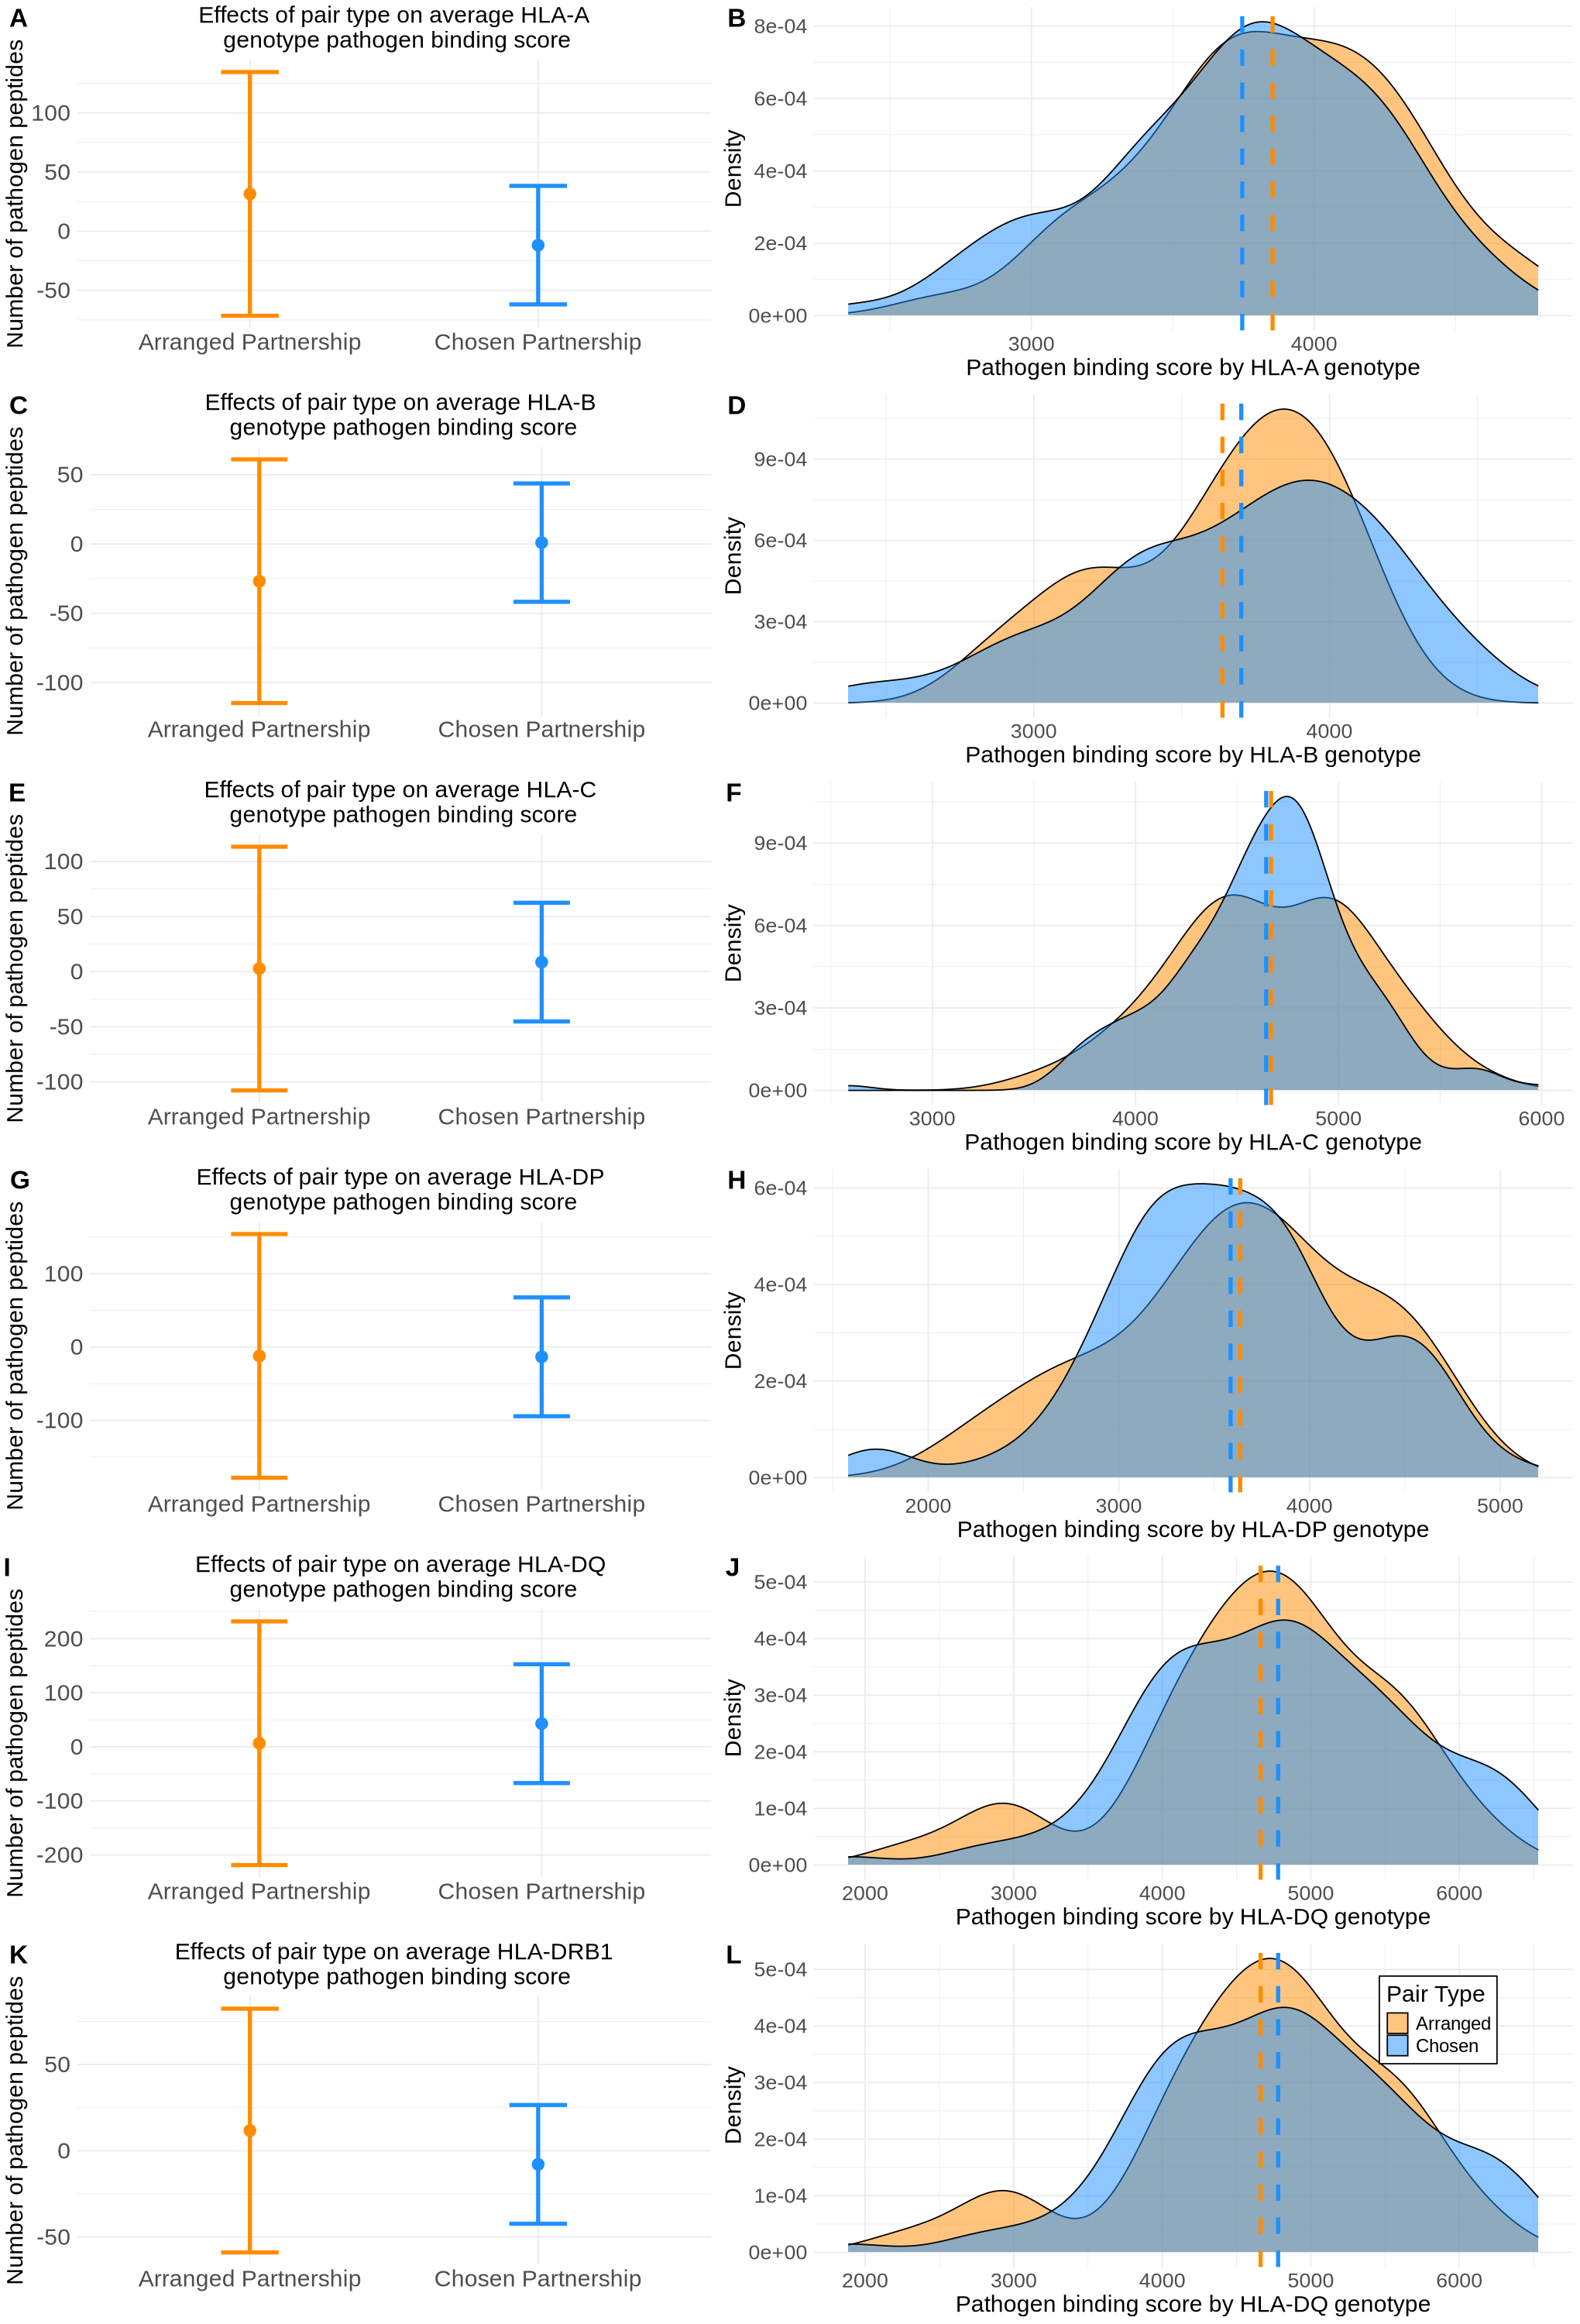

In [58]:
plot1 <- plot_all_effects(A_all, plot_title = "Effects of pair type on average HLA-A\n genotype pathogen binding score", y_= "Number of pathogen peptides")
plot2<- plot_distributions(age_gap_restrict, "mean_SB_all_A",  c("arranged", "chosen"), "Pathogen binding score by HLA-A genotype")
plot2 <- plot2 + theme(legend.position = "none")
plot3 <- plot_all_effects(B_all, plot_title = "Effects of pair type on average HLA-B\n genotype pathogen binding score", y_= "Number of pathogen peptides")
plot4<- plot_distributions(age_gap_restrict, "mean_SB_all_B",  c("arranged", "chosen"), "Pathogen binding score by HLA-B genotype")
plot4 <- plot4 + theme(legend.position = "none")
plot5 <- plot_all_effects(C_all, plot_title = "Effects of pair type on average HLA-C\n genotype pathogen binding score", y_= "Number of pathogen peptides")
plot6<- plot_distributions(age_gap_restrict, "mean_SB_all_C",  c("arranged", "chosen"), "Pathogen binding score by HLA-C genotype")
plot6 <- plot6 + theme(legend.position = "none")
plot7 <- plot_all_effects(DP_all, plot_title = "Effects of pair type on average HLA-DP\n genotype pathogen binding score", y_= "Number of pathogen peptides")
plot8<- plot_distributions(age_gap_restrict, "mean_SB_all_DP",  c("arranged", "chosen"), "Pathogen binding score by HLA-DP genotype")
plot8 <- plot8 + theme(legend.position = "none")
plot9 <- plot_all_effects(DQ_all, plot_title = "Effects of pair type on average HLA-DQ\n genotype pathogen binding score", y_= "Number of pathogen peptides")
plot10 <- plot_distributions(age_gap_restrict, "mean_SB_all_DQ",  c("arranged", "chosen"), "Pathogen binding score by HLA-DQ genotype")
plot10 <- plot10 + theme(legend.position = "none")
plot11 <- plot_all_effects(DRB1_all, plot_title = "Effects of pair type on average HLA-DRB1\n genotype pathogen binding score", y_= "Number of pathogen peptides")
plot12 <- plot_distributions(age_gap_restrict, "mean_SB_all_DQ",  c("arranged", "chosen"), "Pathogen binding score by HLA-DQ genotype")
plot12 <- plot12 + theme(
  legend.position = c(0.9, 0.9),  # Adjust the position as needed (0.9 is near the top-right corner)
  legend.justification = c(1, 1),  # Ensures the legend is aligned to the top-right
  legend.background = element_rect(fill = "white", color = "black")  # Optional: background for the legend
)
options(repr.plot.width = 17, repr.plot.height = 25)
plot_grid(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, plot9, plot10, plot11, plot12,  ncol = 2, nrow=6, labels = c("A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"), label_size = 20, rel_widths = c(1, 1.2))


In [59]:
##Pathogen binding cell type restrict figure S6
A_all <- lmerTest::lmer(mean_SB_int_A ~ 1 + IBD + arranged + chosen + (1|actorID) + (1|partnerID), data=age_gap_restrict)
B_all <- lmerTest::lmer(mean_SB_int_B ~ 1 + IBD + arranged + chosen + (1|actorID) + (1|partnerID), data=age_gap_restrict)
C_all <- lmerTest::lmer(mean_SB_int_C ~ 1 + IBD + arranged + chosen + (1|actorID) + (1|partnerID), data=age_gap_restrict)
DP_all <- lmerTest::lmer(mean_SB_ex_DP ~ 1 + IBD + arranged + chosen + (1|actorID) + (1|partnerID), data=age_gap_restrict)
DQ_all <- lmerTest::lmer(mean_SB_ex_DQ ~ 1 + IBD + arranged + chosen + (1|actorID) + (1|partnerID), data=age_gap_restrict)
DRB1_all <- lmerTest::lmer(mean_SB_ex_DRB1 ~ 1 + IBD + arranged + chosen + (1|actorID) + (1|partnerID), data=age_gap_restrict)

for(gene in c("A", "B", "C", "DP", "DQ", "DRB1")){
print(gene)
con <- generate_contrasts(get(paste0(gene, "_all")), 4)
contrast_results <- do.call(rbind, lapply(names(con), function(contrast_name) {
    contrast_vector <- con[[contrast_name]]
    plot_contrast(contrast_vector, get(paste0(gene, "_all")), contrast_name)
  }))
print(contrast_results)
print("variance by random effects")
calculate_random_effect_variance(get(paste0(gene, "_all")))
}

[1] "A"
[1] "Variable names in the model:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Number of fixed effects: 4"
[1] "Starting index i: 3"
            contrast estimate  lower_CI upper_CI   z_value   p_value
1 arranged vs chosen 21.11782 -42.70077 84.93641 0.6485717 0.5166153
[1] "variance by random effects"
        grp        var1 var2     vcov    sdcor
1   actorID (Intercept) <NA> 28941.22 170.1212
2 partnerID (Intercept) <NA> 34810.10 186.5746
3  Residual        <NA> <NA> 38521.67 196.2694
[1] "B"
[1] "Variable names in the model:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Number of fixed effects: 4"
[1] "Starting index i: 3"
            contrast  estimate lower_CI upper_CI    z_value   p_value
1 arranged vs chosen -18.43385 -80.7774  43.9097 -0.5795362 0.5622274
[1] "variance by random effects"
        grp        var1 var2     vcov    sdcor
1   actorID (Intercept) <NA> 18127.31 134.6377
2 partnerID (Intercept) <NA> 11884.63 109.0166
3  

[1] "Fixed Effects Coefficients:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Fixed Effects Coefficients:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Fixed Effects Coefficients:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Fixed Effects Coefficients:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Fixed Effects Coefficients:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Fixed Effects Coefficients:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     


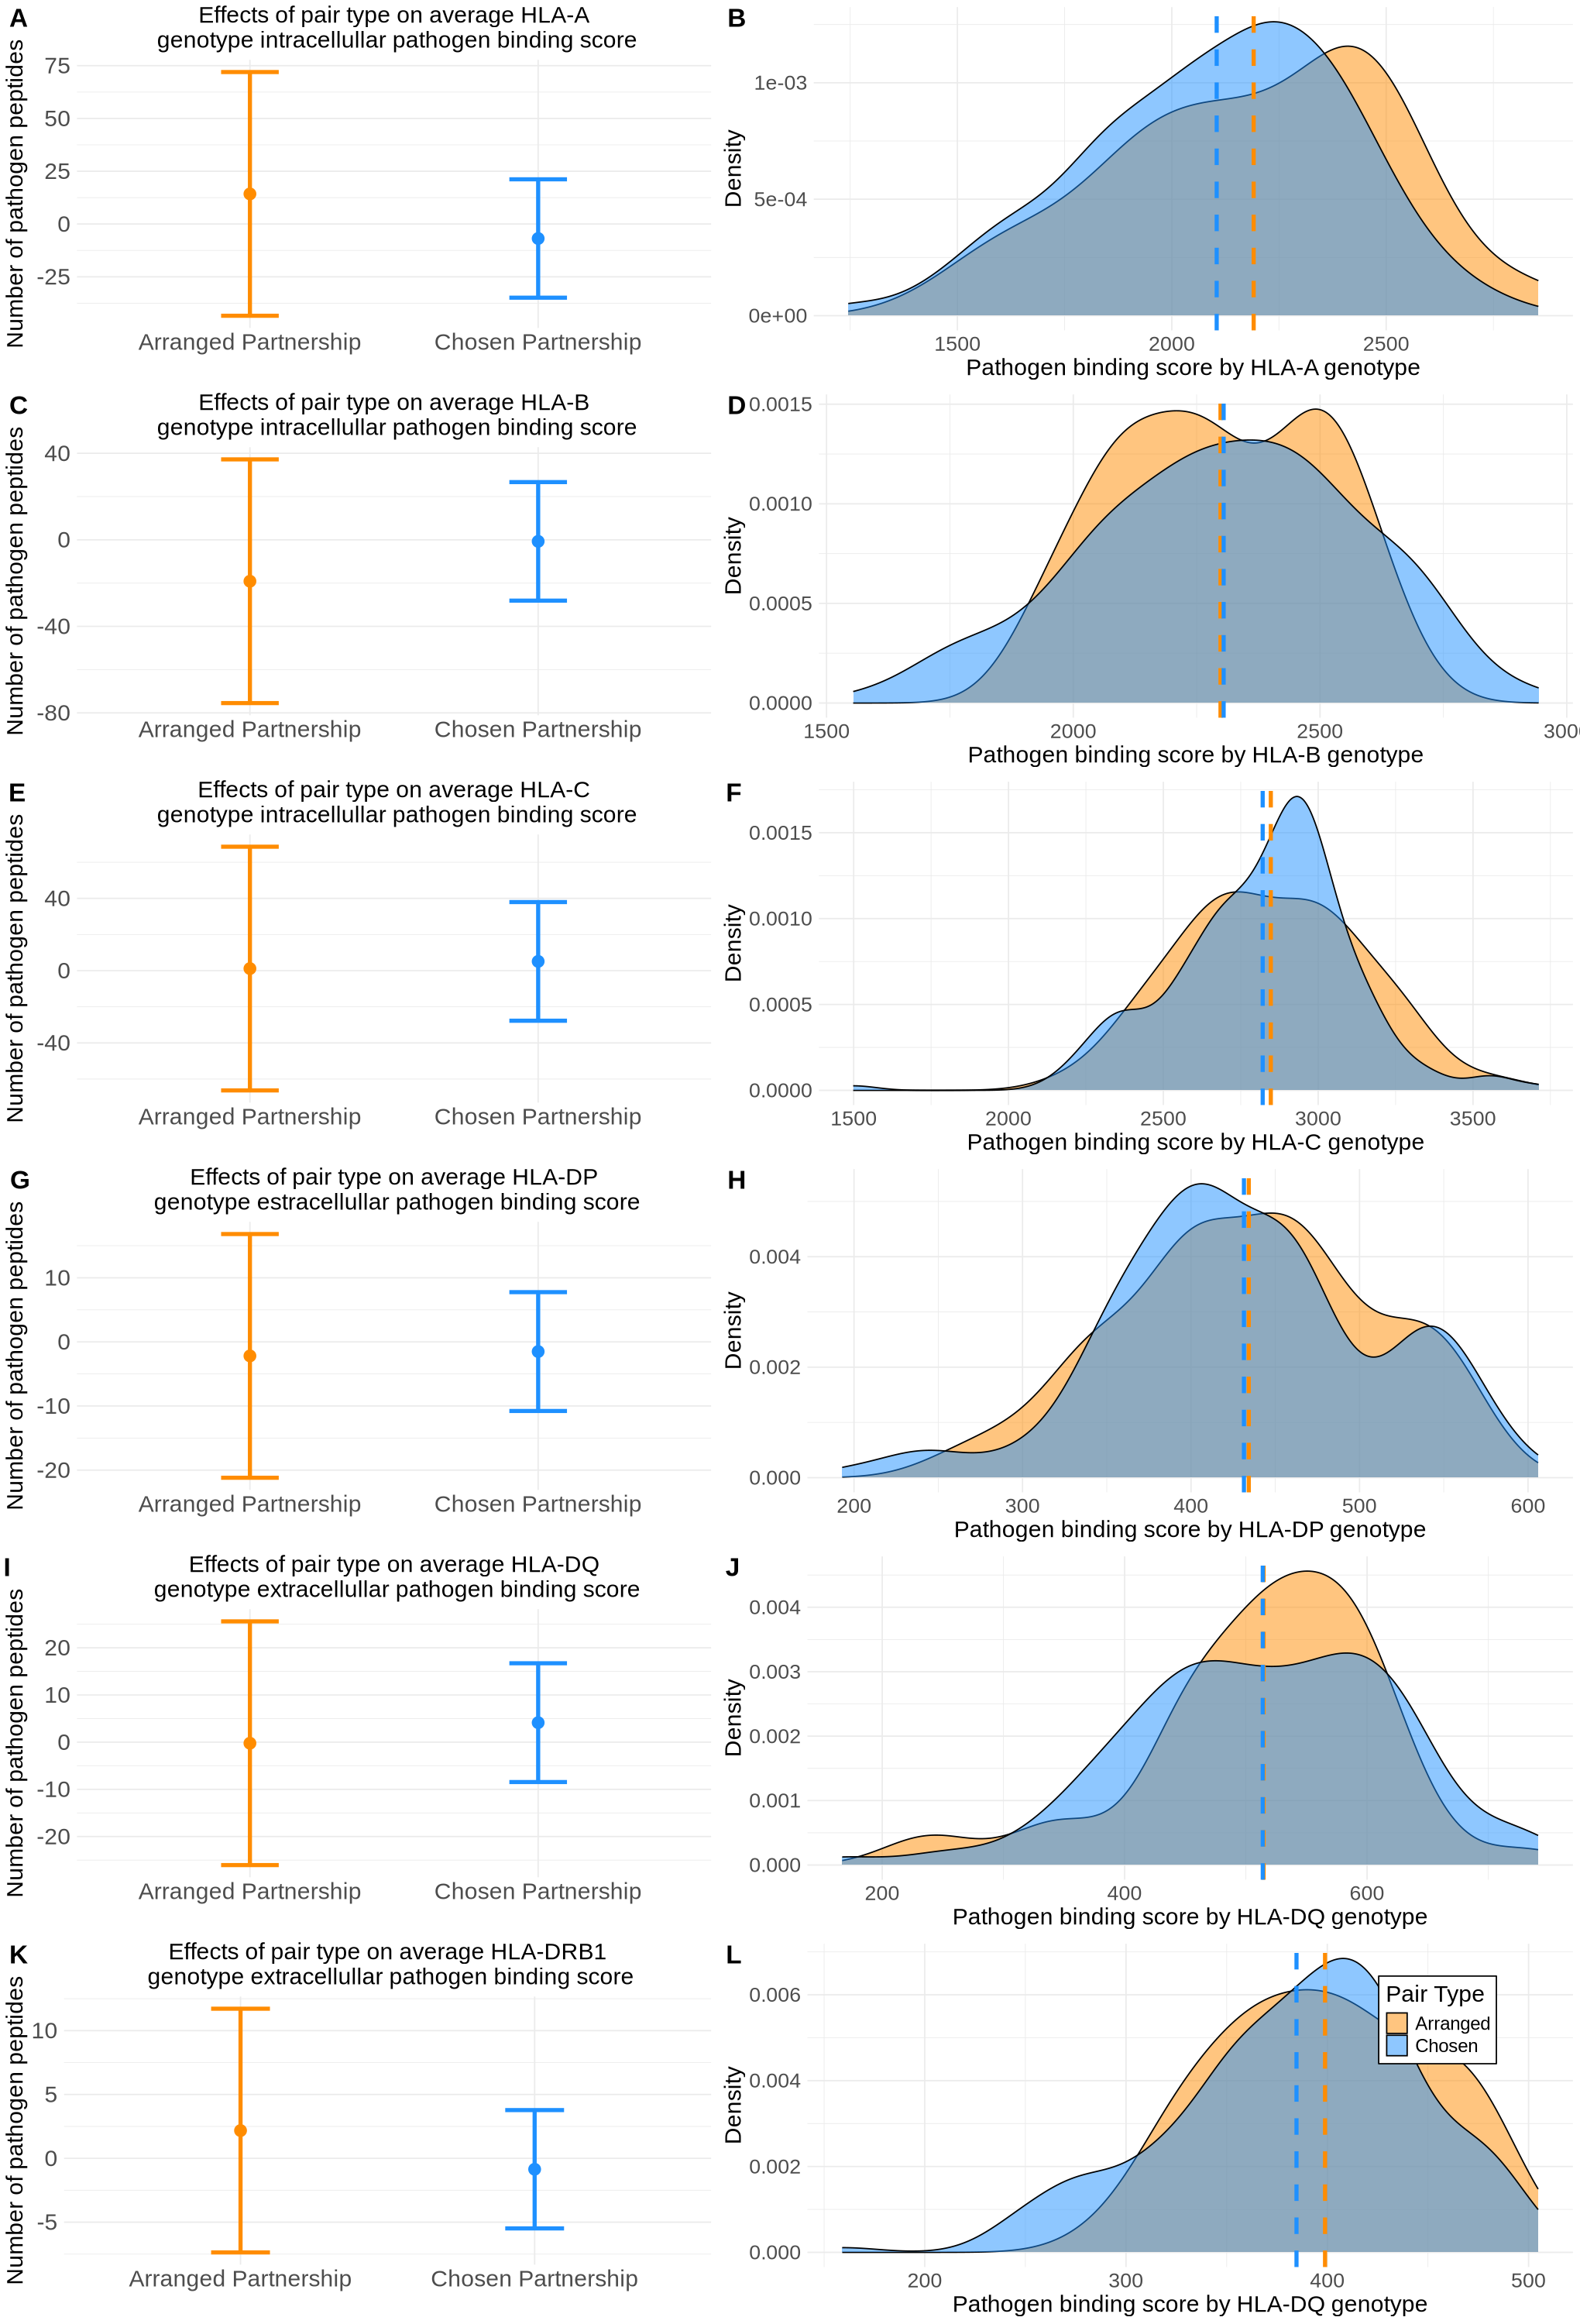

In [60]:
#dividing to intra and ex
plot1 <- plot_all_effects(A_all, plot_title = "Effects of pair type on average HLA-A\n genotype intracellullar pathogen binding score", y_= "Number of pathogen peptides")
plot2<- plot_distributions(age_gap_restrict, "mean_SB_int_A",  c("arranged", "chosen"), "Pathogen binding score by HLA-A genotype")
plot2 <- plot2 + theme(legend.position = "none")
plot3 <- plot_all_effects(B_all, plot_title = "Effects of pair type on average HLA-B\n genotype intracellullar pathogen binding score", y_= "Number of pathogen peptides")
plot4<- plot_distributions(age_gap_restrict, "mean_SB_int_B",  c("arranged", "chosen"), "Pathogen binding score by HLA-B genotype")
plot4 <- plot4 + theme(legend.position = "none")
plot5 <- plot_all_effects(C_all, plot_title = "Effects of pair type on average HLA-C\n genotype intracellullar pathogen binding score", y_= "Number of pathogen peptides")
plot6<- plot_distributions(age_gap_restrict, "mean_SB_int_C",  c("arranged", "chosen"), "Pathogen binding score by HLA-C genotype")
plot6 <- plot6 + theme(legend.position = "none")
plot7 <- plot_all_effects(DP_all, plot_title = "Effects of pair type on average HLA-DP\n genotype estracellullar pathogen binding score", y_= "Number of pathogen peptides")
plot8<- plot_distributions(age_gap_restrict, "mean_SB_ex_DP",  c("arranged", "chosen"), "Pathogen binding score by HLA-DP genotype")
plot8 <- plot8 + theme(legend.position = "none")
plot9 <- plot_all_effects(DQ_all, plot_title = "Effects of pair type on average HLA-DQ\n genotype extracellullar pathogen binding score", y_= "Number of pathogen peptides")
plot10 <- plot_distributions(age_gap_restrict, "mean_SB_ex_DQ",  c("arranged", "chosen"), "Pathogen binding score by HLA-DQ genotype")
plot10 <- plot10 + theme(legend.position = "none")
plot11 <- plot_all_effects(DRB1_all, plot_title = "Effects of pair type on average HLA-DRB1\n genotype extracellullar pathogen binding score", y_= "Number of pathogen peptides")
plot12 <- plot_distributions(age_gap_restrict, "mean_SB_ex_DRB1",  c("arranged", "chosen"), "Pathogen binding score by HLA-DQ genotype")
plot12 <- plot12 + theme(
  legend.position = c(0.9, 0.9),  # Adjust the position as needed (0.9 is near the top-right corner)
  legend.justification = c(1, 1),  # Ensures the legend is aligned to the top-right
  legend.background = element_rect(fill = "white", color = "black")  # Optional: background for the legend
)
options(repr.plot.width = 17, repr.plot.height = 25)
plot_grid(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, plot9, plot10, plot11, plot12,  ncol = 2, nrow=6, labels = c("A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"), label_size = 20, rel_widths = c(1, 1.2))


[1] "Fixed Effects Coefficients:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: mean_divergence ~ 1 + IBD + arranged + chosen + (1 | actorID) +  
    (1 | partnerID)
   Data: age_gap_restrict

REML criterion at convergence: 46509.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.8013 -0.5412  0.0524  0.5707  3.6654 

Random effects:
 Groups    Name        Variance Std.Dev.
 actorID   (Intercept) 0.04275  0.2068  
 partnerID (Intercept) 0.04467  0.2114  
 Residual              0.67417  0.8211  
Number of obs: 18736, groups:  actorID, 215; partnerID, 144

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  5.115e+00  2.566e-02  3.474e+02 199.332   <2e-16 ***
IBD         -4.840e-04  5.658e-05  1.872e+04  -8.555   <2e-16 ***
arranged    -3.974e-02  1.213e-01  1.863e+04  -0.328    0.743    
chosen       2.322e-02  5.913e-02  1.865e+04   0.393    0.695    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’

        grp        var1 var2       vcov     sdcor
1   actorID (Intercept) <NA> 0.04274753 0.2067548
2 partnerID (Intercept) <NA> 0.04467458 0.2113636
3  Residual        <NA> <NA> 0.67417128 0.8210793


[1] 0.1147884

[1] "Variable names in the model:"
[1] "(Intercept)" "IBD"         "arranged"    "chosen"     
[1] "Number of fixed effects: 4"
[1] "Starting index i: 3"


contrast,estimate,lower_CI,upper_CI,z_value,p_value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
arranged vs chosen,-0.06295686,-0.3266811,0.2007674,-0.4678958,0.6398591


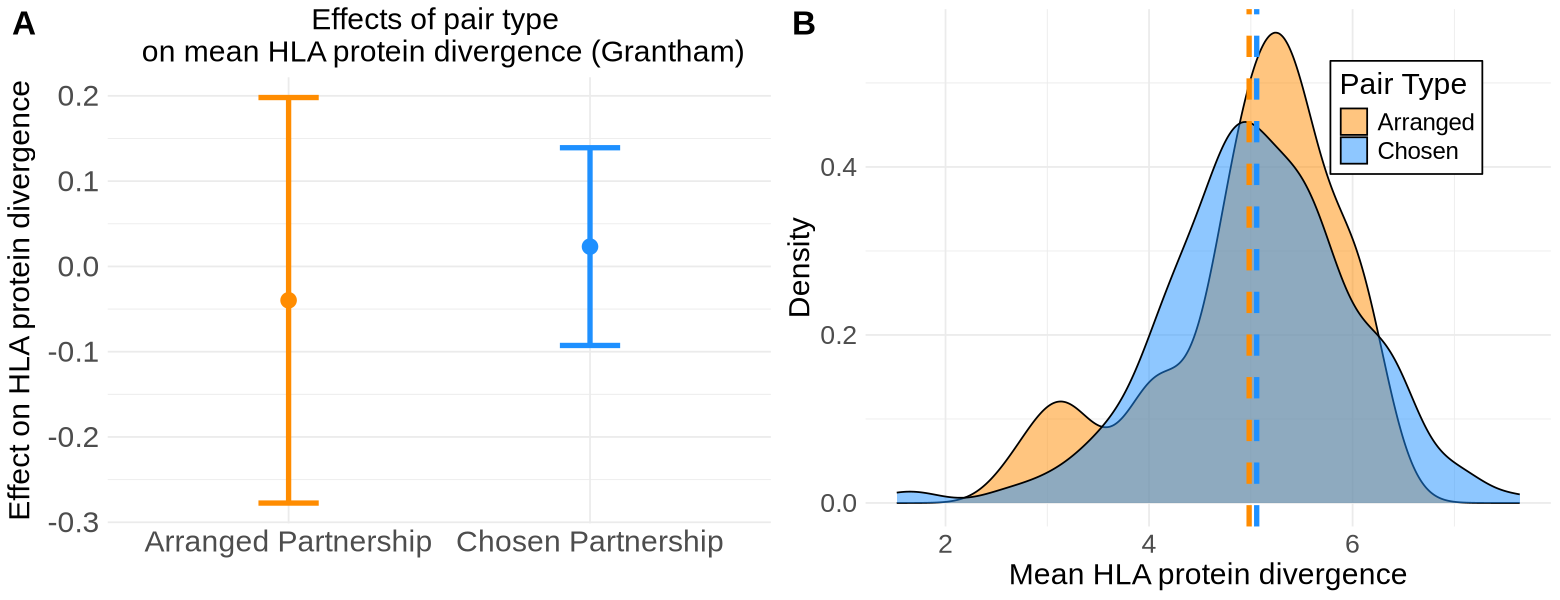

In [63]:
#Protein divergence of peptide binding groove figure S7
age_gap_restrict$mean_divergence <- rowMeans(
  age_gap_restrict[, c("Class1_divergence", "DRB1_DQB1_divergence", 
                       "DPA1_divergence", "DPB1_divergence", "DQA1_divergence")],
  na.rm = TRUE
)

full_model_diverge <- lmerTest::lmer(mean_divergence ~ 1 + IBD + arranged + chosen + (1|actorID) + (1|partnerID), data=age_gap_restrict)

plot1 <- plot_all_effects(full_model_diverge, plot_title = "Effects of pair type \n on mean HLA protein divergence (Grantham)", y_= "Effect on HLA protein divergence")

# Example usage:
plot3<- plot_distributions(age_gap_restrict, "mean_divergence", c("arranged", "chosen"), "Mean HLA protein divergence")

plot3<- plot3 + theme(
  legend.position = c(0.9, 0.9),  # Adjust the position as needed (0.9 is near the top-right corner)
  legend.justification = c(1, 1),  # Ensures the legend is aligned to the top-right
  legend.background = element_rect(fill = "white", color = "black")  # Optional: background for the legend
)


options(repr.plot.width = 13, repr.plot.height = 5)
library(cowplot)
top <- plot_grid(plot1, plot3, ncol = 2, nrow = 1, labels = c("A", "B"), label_size = 20, rel_widths = c(1, 1))
top
summary(full_model_diverge)
calculate_random_effect_variance(full_model_diverge)
div_con <- generate_contrasts(full_model_diverge, 4)


div_contrast_results <- do.call(rbind, lapply(names(div_con), function(contrast_name) {
    contrast_vector <- div_con[[contrast_name]]
    plot_contrast(contrast_vector, full_model_diverge, contrast_name)
  }))

div_contrast_results 